In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import math
import numpy as np
import matplotlib.pyplot as plt

import json

import keras_tuner as kt
import tensorflow as tf

from geexhp import datavis as dvis
dvis.configure_matplotlib()

strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [2]:
with open('normalization_stats.json') as f:
    stats = json.load(f)

input_stats = {
    'UV': (stats['inputs']['UV']['mean'], stats['inputs']['UV']['std']),
    'Vis': (stats['inputs']['Vis']['mean'], stats['inputs']['Vis']['std']),
    'NIR': (stats['inputs']['NIR']['mean'], stats['inputs']['NIR']['std'])
}

output_stats = {
    key: (stats['outputs'][key]['mean'], stats['outputs'][key]['std'])
    for key in stats['outputs']
}

In [3]:
def parse_example(example_proto, input_stats, output_stats):
    raw_input_features = {
        'NOISY_ALBEDO_B-NIR': tf.io.VarLenFeature(tf.float32),
        'NOISY_ALBEDO_B-UV': tf.io.VarLenFeature(tf.float32),
        'NOISY_ALBEDO_B-Vis': tf.io.VarLenFeature(tf.float32),
    }

    raw_output_features = {
        "OBJECT-RADIUS-REL-EARTH": tf.io.FixedLenFeature([], tf.float32),
        "OBJECT-GRAVITY": tf.io.FixedLenFeature([], tf.float32),
        "ATMOSPHERE-TEMPERATURE": tf.io.FixedLenFeature([], tf.float32),
        "ATMOSPHERE-PRESSURE": tf.io.FixedLenFeature([], tf.float32),

        # 'Earth_type' : tf.io.FixedLenFeature([], tf.string),

        'log_C2H6': tf.io.FixedLenFeature([], tf.float32),
        'log_CH4': tf.io.FixedLenFeature([], tf.float32),
        'log_CO': tf.io.FixedLenFeature([], tf.float32),
        'log_CO2': tf.io.FixedLenFeature([], tf.float32),
        'log_H2O': tf.io.FixedLenFeature([], tf.float32),
        'log_N2': tf.io.FixedLenFeature([], tf.float32),
        'log_N2O': tf.io.FixedLenFeature([], tf.float32),
        'log_O2': tf.io.FixedLenFeature([], tf.float32),
        'log_O3': tf.io.FixedLenFeature([], tf.float32)
    }

    all_features = {**raw_input_features, **raw_output_features}
    parsed = tf.io.parse_single_example(example_proto, all_features)

    # ----------------------
    # Input Normalization
    # ----------------------
    normalized_inputs = {}
    for region in ['UV', 'Vis', 'NIR']:
        # Get raw spectrum
        spectrum = parsed[f'NOISY_ALBEDO_B-{region}']
        if isinstance(spectrum, tf.SparseTensor):
            spectrum = tf.sparse.to_dense(spectrum, default_value=0.0)
        
        # Normalize using dataset statistics
        mean = input_stats[region][0]
        std = input_stats[region][1]
        normalized = (spectrum - mean) / std
        
        # Reshape to appropriate dimensions
        if region == 'UV':
            normalized = tf.reshape(normalized, [8, 1])
        elif region == 'Vis':
            normalized = tf.reshape(normalized, [94, 1])
        elif region == 'NIR':
            normalized = tf.reshape(normalized, [49, 1])
            
        normalized_inputs[f'NOISY_ALBEDO_B-{region}'] = normalized

    # ----------------------
    # Output Processing
    # ----------------------
    processed_outputs = {}
    
    radius = parsed['OBJECT-RADIUS-REL-EARTH']
    processed_outputs['OBJECT-RADIUS-REL-EARTH'] = (radius - output_stats['OBJECT-RADIUS-REL-EARTH'][0]) / output_stats['OBJECT-RADIUS-REL-EARTH'][1]
    
    gravity = parsed['OBJECT-GRAVITY']
    processed_outputs['OBJECT-GRAVITY'] = (gravity - output_stats['OBJECT-GRAVITY'][0]) / output_stats['OBJECT-GRAVITY'][1]
    
    temperature = parsed['ATMOSPHERE-TEMPERATURE']
    processed_outputs['ATMOSPHERE-TEMPERATURE'] = (temperature - output_stats['ATMOSPHERE-TEMPERATURE'][0]) / output_stats['ATMOSPHERE-TEMPERATURE'][1]
    
    pressure = parsed['ATMOSPHERE-PRESSURE']
    processed_outputs['ATMOSPHERE-PRESSURE'] = (pressure - output_stats['ATMOSPHERE-PRESSURE'][0]) / output_stats['ATMOSPHERE-PRESSURE'][1]
    
    for chem in ['log_C2H6', 'log_CH4', 'log_CO', 'log_CO2', 'log_H2O', 'log_N2', 'log_N2O', 'log_O2', 'log_O3']:
        chem_value = parsed[chem]
        processed_outputs[f'{chem}'] = (chem_value - output_stats[f'{chem}'][0]) /  output_stats[f'{chem}'][1]

    # processed_outputs['Earth_type'] = parsed['Earth_type']

    return normalized_inputs, processed_outputs

In [4]:
def read_tfrecord(file_path, input_stats, output_stats, 
                    batch_size=1000, shuffle_buffer=True, repeat=False):
    
    dataset = tf.data.TFRecordDataset(file_path, num_parallel_reads=tf.data.AUTOTUNE)

    if shuffle_buffer:
        dataset = dataset.shuffle(buffer_size=dataset.cardinality())

    # Parse the dataset after shuffling
    parsed_dataset = dataset.map(
        lambda x: parse_example(x, input_stats, output_stats), 
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Repeat the dataset for multiple epochs
    if repeat:
        parsed_dataset = parsed_dataset.repeat()

    # Batch after shuffling and parsing
    parsed_dataset = parsed_dataset.batch(batch_size, drop_remainder=False)
    parsed_dataset = parsed_dataset.prefetch(tf.data.AUTOTUNE)
    
    return parsed_dataset

In [5]:
train_ds = read_tfrecord("../data/train.tfrecord", input_stats, output_stats)
val_ds = read_tfrecord("../data/val.tfrecord", input_stats, output_stats)
test_ds = read_tfrecord("../data/test.tfrecord", input_stats, output_stats)

In [6]:
batch = next(iter(train_ds.take(1)))

print("\n## Input Shapes:")
for k,v in batch[0].items():
    print(f"> {k}: {v.shape}") 

print("\n## Output Ranges (standardized):")
for k,v in batch[1].items():
    if k != 'Earth_type':
        print(f"> {k}: {tf.reduce_mean(v):.3f} ± {tf.math.reduce_std(v):.6f}")


## Input Shapes:
> NOISY_ALBEDO_B-UV: (1000, 8, 1)
> NOISY_ALBEDO_B-Vis: (1000, 94, 1)
> NOISY_ALBEDO_B-NIR: (1000, 49, 1)

## Output Ranges (standardized):
> OBJECT-RADIUS-REL-EARTH: 0.012 ± 0.992919
> OBJECT-GRAVITY: 0.012 ± 0.991699
> ATMOSPHERE-TEMPERATURE: -0.003 ± 1.004841
> ATMOSPHERE-PRESSURE: 0.009 ± 0.989823
> log_C2H6: -0.007 ± 1.012291
> log_CH4: -0.007 ± 0.987848
> log_CO: -0.011 ± 1.003955
> log_CO2: -0.019 ± 1.015556
> log_H2O: -0.000 ± 1.002527
> log_N2: -0.023 ± 1.054399
> log_N2O: 0.014 ± 0.990049
> log_O2: 0.001 ± 1.007112
> log_O3: 0.008 ± 0.991732


In [7]:
def plot_spectrum(ds, sample_number):
    for batch in ds.take(1):
        pass

    x1 = batch[0]['NOISY_ALBEDO_B-UV'][sample_number]
    x2 = batch[0]['NOISY_ALBEDO_B-Vis'][sample_number]
    x3 = batch[0]['NOISY_ALBEDO_B-NIR'][sample_number]

    UV = np.array([0.2       , 0.22857143, 0.26122449, 0.29854227, 0.34119117,
       0.38993277, 0.44563745, 0.50929994])
    VIS = np.array([0.515     , 0.51867857, 0.52238342, 0.52611473, 0.52987269,
       0.5336575 , 0.53746934, 0.5413084 , 0.54517489, 0.549069  ,
       0.55299092, 0.55694085, 0.560919  , 0.56492557, 0.56896075,
       0.57302475, 0.57711779, 0.58124006, 0.58539177, 0.58957314,
       0.59378438, 0.5980257 , 0.60229731, 0.60659943, 0.61093229,
       0.61529609, 0.61969106, 0.62411742, 0.62857541, 0.63306523,
       0.63758712, 0.64214132, 0.64672804, 0.65134753, 0.65600001,
       0.66068572, 0.66540491, 0.6701578 , 0.67494464, 0.67976568,
       0.68462114, 0.6895113 , 0.69443638, 0.69939664, 0.70439233,
       0.7094237 , 0.71449101, 0.71959452, 0.72473448, 0.72991116,
       0.73512481, 0.7403757 , 0.7456641 , 0.75099027, 0.75635448,
       0.76175702, 0.76719814, 0.77267812, 0.77819725, 0.78375581,
       0.78935406, 0.7949923 , 0.80067082, 0.8063899 , 0.81214983,
       0.8179509 , 0.8237934 , 0.82967764, 0.83560391, 0.84157251,
       0.84758374, 0.85363791, 0.85973532, 0.86587629, 0.87206112,
       0.87829013, 0.88456363, 0.89088194, 0.89724539, 0.90365428,
       0.91010895, 0.91660973, 0.92315694, 0.92975092, 0.936392  ,
       0.94308052, 0.9498168 , 0.95660121, 0.96343408, 0.97031575,
       0.97724657, 0.98422691, 0.9912571 , 0.99833751])
    NIR = np.array([1.01      , 1.02442857, 1.03906327, 1.05390703, 1.06896284,
       1.08423374, 1.09972279, 1.11543312, 1.13136788, 1.14753028,
       1.16392356, 1.18055104, 1.19741606, 1.214522  , 1.23187232,
       1.24947049, 1.26732007, 1.28542464, 1.30378785, 1.32241339,
       1.34130501, 1.36046651, 1.37990175, 1.39961463, 1.41960913,
       1.43988926, 1.4604591 , 1.48132281, 1.50248456, 1.52394862,
       1.54571932, 1.56780102, 1.59019818, 1.6129153 , 1.63595694,
       1.65932776, 1.68303244, 1.70707576, 1.73146256, 1.75619774,
       1.78128628, 1.80673322, 1.8325437 , 1.85872289, 1.88527608,
       1.91220859, 1.93952586, 1.96723337, 1.9953367 ])

    plt.plot(UV, x1, label='UV')
    plt.plot(VIS, x2, label='Vis')
    plt.plot(NIR, x3, label='NIR')
    plt.legend()
    plt.show()

    for output in batch[1].keys():
        print(f'> {output}: \t {batch[1][output][sample_number]}')

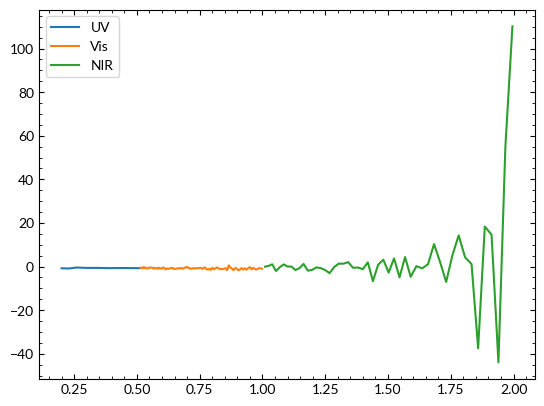

> OBJECT-RADIUS-REL-EARTH: 	 -0.9531570672988892
> OBJECT-GRAVITY: 	 -0.949059784412384
> ATMOSPHERE-TEMPERATURE: 	 1.7062015533447266
> ATMOSPHERE-PRESSURE: 	 -1.015189528465271
> log_C2H6: 	 -1.3975906372070312
> log_CH4: 	 0.6046364307403564
> log_CO: 	 0.6345879435539246
> log_CO2: 	 -1.0736188888549805
> log_H2O: 	 -1.0516092777252197
> log_N2: 	 0.5055323839187622
> log_N2O: 	 1.371329665184021
> log_O2: 	 0.9238318204879761
> log_O3: 	 1.3605650663375854


In [8]:
plot_spectrum(train_ds, 0)

In [9]:
TRAIN_SAMPLES = 779887
VAL_SAMPLES = 66676
BATCH_SIZE = 1000

steps_per_epoch = math.ceil(TRAIN_SAMPLES / BATCH_SIZE)
validation_steps = math.ceil(VAL_SAMPLES / BATCH_SIZE)

In [10]:
def conv_1D_block(input_tensor, num_filters, kernel_size=3, strides=1,
                    kernel_initializer='glorot_uniform', activation='swish'):
    input_shape = input_tensor.shape[1]  # Get input sequence length
    kernel_size = min(kernel_size, input_shape)  # Ensure kernel <= input size

    z = tf.keras.layers.Conv1D(num_filters, kernel_size, strides=strides,
                                kernel_initializer=kernel_initializer,
                                activation=activation, padding="same")(input_tensor)  
    z = tf.keras.layers.Conv1D(num_filters, kernel_size, strides=strides,
                                kernel_initializer=kernel_initializer,
                                activation=activation, padding="same")(z)

    if z.shape[1] > 2:  # Prevent excessive pooling
        z = tf.keras.layers.MaxPooling1D(pool_size=2)(z)
    
    return z

In [11]:
def build_model_3(hp):
    outputs_list = [
        "OBJECT-RADIUS-REL-EARTH",
        "OBJECT-GRAVITY",
        "ATMOSPHERE-TEMPERATURE",
        "ATMOSPHERE-PRESSURE",
        'log_C2H6',
        'log_CH4',
        'log_CO',
        'log_CO2',
        'log_H2O',
        'log_N2',
        'log_N2O',
        'log_O2',
        'log_O3'
    ]

    # Hyperparameters
    dense_l2 = hp.Choice('dense_l2', [1e-4, 1e-3, 1e-2])
    concat_filters = hp.Int('concat_filters', min_value=4, max_value=64, step=8) 
    uv_filters = hp.Choice('uv_filters', [4, 8])
    vis_filters = hp.Int('vis_filters', min_value=8, max_value=64, step=8)
    nir_filters = hp.Int('nir_filters', min_value=8, max_value=64, step=8)
    kernel_size = hp.Choice('kernel_size', [2, 3, 5])
    uv_kernel = hp.Choice('uv_kernel', [2, 3])
    dense_units1 = hp.Int('dense_units1', min_value=64, max_value=256, step=32)
    dense_units2 = hp.Int('dense_units2', min_value=32, max_value=256, step=32)
    dropout_rate = hp.Choice('dropout_rate',   [0.1, 0.2, 0.3, 0.4, 0.5])
    lr = hp.Choice('learning_rate',  [1e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2])

    # Inputs
    input_uv = tf.keras.layers.Input(shape=(8, 1), name='NOISY_ALBEDO_B-UV')
    input_vis = tf.keras.layers.Input(shape=(94, 1), name='NOISY_ALBEDO_B-Vis')
    input_nir = tf.keras.layers.Input(shape=(49, 1), name='NOISY_ALBEDO_B-NIR')

    # First convolutional branch of the network.
    concat_branch = tf.keras.layers.Concatenate(axis=1)([input_uv, input_vis, input_nir])
    concat_branch = conv_1D_block(concat_branch, concat_filters, kernel_size)
    concat_branch = conv_1D_block(concat_branch, max(8, concat_filters//2), kernel_size)
    concat_branch = tf.keras.layers.GlobalAveragePooling1D()(concat_branch)

    # UV convolutional branch.
    UV = conv_1D_block(input_uv, uv_filters, uv_kernel)
    UV = tf.keras.layers.GlobalAveragePooling1D()(UV)

    # Vis convolutional branch.
    VIS = conv_1D_block(input_vis, vis_filters, kernel_size)
    VIS = conv_1D_block(VIS, max(8, vis_filters//2), kernel_size)
    VIS = conv_1D_block(VIS, max(8, vis_filters//4), kernel_size)
    VIS = tf.keras.layers.GlobalAveragePooling1D()(VIS)

    # NIR convolutional branch.
    NIR = conv_1D_block(input_nir, nir_filters, kernel_size)
    NIR = conv_1D_block(NIR, max(8, nir_filters//2), kernel_size)
    NIR = tf.keras.layers.GlobalAveragePooling1D()(NIR)
    
    combined_braches = tf.keras.layers.Concatenate()([concat_branch, UV, VIS, NIR])

    x = tf.keras.layers.Dense(dense_units1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(dense_l2))(combined_braches)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(dense_units2, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(dense_l2))(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    x = tf.keras.layers.Dense(32, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(dense_l2))(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Output Layers
    outputs = {}
    for output_name in outputs_list:
        output = tf.keras.layers.Dense(units=1, activation='linear', kernel_regularizer=tf.keras.regularizers.l1(1e-5), name=output_name)(x)
        outputs[output_name] = output

    losses = {output_name: 'mae' for output_name in outputs_list}

    inpts = [input_uv, input_vis, input_nir]

    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    model = tf.keras.Model(inputs=inpts, outputs=outputs, name="test_5")
    model.compile(optimizer=opt, loss=losses)

    return model

In [12]:
tuner = kt.BayesianOptimization(
    build_model_3,
    objective='val_loss',
    max_trials=10,
    directory='opt',
    project_name='bayesopt'
)

In [13]:
tuner.search(train_ds, epochs=5, validation_data=val_ds)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
0.0001            |0.0001            |dense_l2
28                |28                |concat_filters
8                 |8                 |uv_filters
40                |40                |vis_filters
24                |24                |nir_filters
2                 |2                 |kernel_size
3                 |3                 |uv_kernel
64                |64                |dense_units1
32                |32                |dense_units2
0.3               |0.3               |dropout_rate
0.0005            |0.0005            |learning_rate

Epoch 1/5
     70/Unknown 23s 149ms/step - ATMOSPHERE-PRESSURE_loss: 0.8928 - ATMOSPHERE-TEMPERATURE_loss: 0.7988 - OBJECT-GRAVITY_loss: 0.8698 - OBJECT-RADIUS-REL-EARTH_loss: 0.8660 - log_C2H6_loss: 0.9206 - log_CH4_loss: 0.8519 - log_CO2_loss: 0.8334 - log_CO_loss: 0.8394 - log_H2O_loss: 0.8306 - log_N2O_loss: 0.9117 - log_N2_loss: 0.5858 - log_O2_loss: 0.8641 - 

KeyboardInterrupt: 

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
best_model = build_model_3(best_hps)

In [ ]:
history = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)